# Importing necessary libraries

In [1]:
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sklearn
from sklearn import linear_model
from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from smt.sampling_methods import LHS

import time
import datetime
import random
import csv
import os
import copy
import json
from tqdm import tqdm



/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
import tensorflow as tf

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages

In [ ]:
# determine the landscape (NK0-NK3)
df = pd.read_csv('NK0.csv')

# To display the first 5 rows of the dataframe
print(df.head())

     Genotype  Phenotype
0  AAAAAAAAAA   0.370336
1  AAAAAAAAAT   0.396512
2  AAAAAAAAAC   0.356335
3  AAAAAAAAAG   0.422462
4  AAAAAAAATA   0.342116


In [4]:
def NK_surrogate(input):
    genotype_to_phenotype = dict(zip(df['Genotype'], df['Phenotype']))
    
    # Use list comprehension to get the phenotype for each genotype in the input list
    # If a genotype is not found in the dictionary, it returns None
    ordered_phenotypes = [genotype_to_phenotype.get(genotype) for genotype in input]
    
    return np.array(ordered_phenotypes)

In [5]:
#test whether the model is implemented
sequence = ["AAAAAAAAAT","AACCTTGTAA"] 
result = NK_surrogate(sequence)
print(result)

[0.39651205 0.45037285]


# Utility functions

In [6]:
def latin_sampling(num):
    xlimits = np.array([[0,1.0]]*10)
    sampling = LHS(xlimits=xlimits,)
    x = sampling(num)
    sequence_list=[]
    for i in range(num):
        oh=""
        for j in range(10):
            if x[i][j]<0.25:
                oh=oh+"A"
            elif x[i][j]<0.5:
                oh=oh+"C"
            elif x[i][j]<0.75:
                oh=oh+"G"
            elif x[i][j]<1:
                oh=oh+"T"             
        sequence_list.append(oh)
    return sequence_list

In [7]:
def random_sampling(num):
    x= np.random.random_sample((num,10))
    sequence_list=[]
    for i in range(num):
        oh=""
        for j in range(10):
            if x[i][j]<0.25:
                oh=oh+"A"
            elif x[i][j]<0.5:
                oh=oh+"C"
            elif x[i][j]<0.75:
                oh=oh+"G"
            elif x[i][j]<1:
                oh=oh+"T"             
        sequence_list.append(oh)
    return sequence_list

In [8]:
def oh_to_seq(onehot):
    mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    sequence=[]
    for i in range(len(onehot)):
        decoded_sequence=[]
        for j in range(10):
            decoded_sequence.append(mapping[int(onehot[i][4*j+1]*1+onehot[i][4*j+2]*2+onehot[i][4*j+3]*3)])
        sequence.append(''.join(decoded_sequence))
    return sequence

In [9]:
def seq_to_oh(sequence):
    onehot=[]
    diction =[['A'], ['C'], ['G'], ['T']]
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(diction)
    for i in range(len(sequence)): 
        sep_seq=list(sequence[i])
        sep_seq=np.array(sep_seq)
        sep_seq=sep_seq.reshape(len(sequence[i]),1)
        A=enc.transform(sep_seq).toarray()
        A=A.reshape(len(sequence[i])*4)
        onehot.append(A)
    onehot=np.array(onehot)
    onehot = onehot.astype('float32')
    return onehot

In [ ]:
# Initial sampling
# sample_X = latin_sampling(2000)
# with open('initial_LHS_2000.txt', 'w') as out_file:
#     json.dump(sample_X, out_file)
# sample_X = random_sampling(2000)
# with open('initial_random1.txt', 'w') as out_file:
#     json.dump(sample_X, out_file)
# sample_X = random_sampling(2000)
# with open('initial_random2.txt', 'w') as out_file:
#     json.dump(sample_X, out_file)

# Defining training functions

In [13]:
def select_current_best_model(X, y, Xplot, yplot, models_number = 10, 
                              verbose = False, 
                             MLP = True,
                             visu = False,
                             model_name = "test"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    trained_model_list = []
    # Training all models
    for i in range(models_number):
        X_train, y_train = X, y
        if MLP:
            other_MLP = MLPRegressor(hidden_layer_sizes  = (10, 100,100, 20), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            other_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(other_MLP)

            big_MLP = MLPRegressor(hidden_layer_sizes  = (100,100, 20),solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            big_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(big_MLP)


            medium_MLP = MLPRegressor(hidden_layer_sizes  = (40, 10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            medium_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(medium_MLP)
  
            small_MLP = MLPRegressor(hidden_layer_sizes  = (10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            small_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(small_MLP)
        
    # Evaluating all 
    all_scores = []
    for i in range(len(trained_model_list)):
        selected_mdoel = trained_model_list[i]
        y_pred = selected_mdoel.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        all_scores.append(score)

    try:
        best_index = all_scores.index(max(all_scores))
        best_score = all_scores[best_index]
    except ValueError:
        best_index = 0
    if verbose:
        print(all_scores)
        print("Best index is {}".format(best_index))
        print("Best score is {}".format(best_score))
    best_model = trained_model_list[best_index]
    if visu:        
        model = best_model
        y_pred = model.predict(Xplot)
        score = sklearn.metrics.r2_score(yplot, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(yplot, y_pred, edgecolors=(0, 0, 0))
        ax.plot([0, 20], [0, 20], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_title("Model prediction for model {}: {}".format(model_name, score))
        ax.set_ylabel('Predicted')
        plt.show()
    return(best_model, best_score)

# Functions for suggesting experimental points

In [14]:
def generate_random_grid(sample_size = 10000, normalisation = True, verbose = True):
    """
    Generates a random grid of desired size avoiding predefined concentrations.
    Can be quite long for big arrays, as it verifies combinations were not previously sampled.
    """
    nucleotides = ['A', 'T', 'C', 'G']
    DNA_random=[]
    for i in range(sample_size):
        DNA_random.append(''.join(random.choice(nucleotides) for _ in range(10)))
    return(DNA_random)

In [ ]:
def select_best_predictions_from_ensemble_model(ensemble_of_models, 
                                                total_sampling_size = 10000,
                                                sample_size = 100,
                                                exploitation = 0.3,
                                                exploration = 0.7, 
                                               initial_max = 1,
                                               verbose = True,
                                               sampling = "random"): 
    """
    Heart of the active learning process.
    Uses a pre-trained ensemble of models to predict on randomly chosen combinations and selects next experiments.
    total_sampling_size: number of combinations to randomly sample
    sample_size: number to export for further analysis
    exploitation: weighting of the yield
    exploration: weighting of the ucnertainty (yield std)
    sampling = ["random", "DE", "drift","recombination"]
    """
    # Random 
    if sampling == "random":
        active_learning_array = generate_random_grid(sample_size = total_sampling_size, normalisation = True)

    # DE
    if sampling == "DE":
        top_100_indices = [index for index, value in sorted(enumerate(data_ym[-1]), key=lambda x: x[1], reverse=True)[:100]]
        selected_elements = [data_X[-1][i] for i in top_100_indices]
        active_learning_array = single_mutant_walking(selected_elements, sample_size=total_sampling_size)

    # genetic drift
    if sampling == "drift":    
        top_100_indices = [index for index, value in sorted(enumerate(data_ym[-1]), key=lambda x: x[1], reverse=True)[:100]]
        selected_elements = [data_X[-1][i] for i in top_100_indices]
        active_learning_array = genetic_drift(selected_elements)
    
    # recombination
    if sampling == "recombination":
        top_100_indices = [index for index, value in sorted(enumerate(data_ym[-1]), key=lambda x: x[1], reverse=True)[:100]]
        selected_elements = [data_X[-1][i] for i in top_100_indices]
        active_learning_array = evolution(selected_elements)
        
        
    # Predicting the full random grid
    active_learning_array = list(set(active_learning_array))
    total_sampling_size = len(active_learning_array)
    answer_array_pred = np.empty
    all_predictions = None
    if verbose:
        print("Starting ensemble predictions")
    for model in ensemble_of_models:
        y_pred = np.array(model.predict(np.array(seq_to_oh(active_learning_array))))
        print(len(y_pred))
        answer_array_pred = y_pred.reshape(total_sampling_size, -1)
        if all_predictions is None:
            all_predictions = y_pred.reshape(total_sampling_size, -1)
        else:
            all_predictions = np.concatenate((all_predictions, y_pred.reshape(total_sampling_size, -1)), axis = 1)
    if verbose:
        print("Finished ensemble predictions")    
        
        
        
    # Obtaining mean and std for predicted array
    y_pred, y_pred_std = np.mean(all_predictions, axis = 1), np.std(all_predictions, axis = 1)
    
    # Create the array to maximise, balancing between exploration and exploitation
    array_to_maximise = copy.deepcopy(exploitation * y_pred + exploration * y_pred_std)
    z_scorearray = copy.copy(array_to_maximise)
    z_exploration = copy.copy(y_pred_std)
    z_exploitation = copy.copy(y_pred)
    z_scorearray = z_scorearray.astype('float32')
    z_exploration = z_exploration.astype('float32')
    z_exploitation = z_exploitation.astype('float32')
    # Select arrays depending on choice of way to eplore: only uncertainty, only yield, or a mix of both.
    conditions_list_pure_exploitation = []
    for count in range(sample_size):
        i = np.argmax(y_pred)
        conditions_list_pure_exploitation.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        y_pred[i] = -1
        
    conditions_list_pure_exploration = []
    for count in range(sample_size):
        i = np.argmax(y_pred_std)
        conditions_list_pure_exploration.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        y_pred_std[i] = -1
    
    conditions_list = []
    for count in range(sample_size):
        i = np.argmax(array_to_maximise)
        conditions_list.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        array_to_maximise[i] = -1
    else:
        active_learning_array =  active_learning_array
    active_learning_array=np.array(seq_to_oh(active_learning_array))       
    conditions_to_test = active_learning_array[conditions_list,:]
    conditions_to_test_eploration = active_learning_array[conditions_list_pure_exploration,:]
    conditions_to_test_exploitation = active_learning_array[conditions_list_pure_exploitation,:]
    return(conditions_to_test, conditions_to_test_eploration, conditions_to_test_exploitation,z_scorearray,z_exploitation,z_exploration)

### Bio-sampling methods

In [21]:
def generate_single_mutations(dna_sequence):
    """
    generate all the single mutation neighbours for a given sequence
    """
    mutation_neighbors = []

    for i in range(len(dna_sequence)):
        for base in ['A', 'T', 'G', 'C']:
            if dna_sequence[i] != base:
                mutated_sequence = list(dna_sequence)
                mutated_sequence[i] = base
                mutation_neighbors.append(''.join(mutated_sequence))

    return mutation_neighbors

In [ ]:
def single_mutant_walking(original_sequences, num_mutations=4, sample_size=10000):
    mutated_sequences = []


    for _ in range(sample_size):    # Randomly select one of the original sequences
        original_seq = random.choice(original_sequences)
        mutated_sequence = list(original_seq)

        # Generate num_mutations random positions for mutations
        mutation_positions = random.sample(range(len(mutated_sequence)), num_mutations)

        for position in mutation_positions:
            # Replace the base at the randomly selected position with a random base
            new_base = random.choice(['A', 'T', 'G', 'C'])
            mutated_sequence[position] = new_base

        mutated_sequences.append(''.join(mutated_sequence))

    return mutated_sequences



In [23]:
def genetic_drift(original_sequences, mutation_probability=0.1, num_sequences=10000):
    mutated_sequences = []

    for _ in range(num_sequences):
        mutated_sequence = ""

        for i in range(len(original_sequences[0])):
            if random.random() < mutation_probability:
                # Mutate the base at the current position
                new_base = random.choice(['A', 'T', 'G', 'C'])
                mutated_sequence += new_base
            else:
                mutated_sequence += random.choice(original_sequences)[i]

        mutated_sequences.append(mutated_sequence)

    return mutated_sequences

In [26]:
from itertools import permutations

def choose_breaking_sites(sequence_length, num_breaks=10):
    # Choose num_breaks random breaking sites
    return sorted(random.sample(range(1, sequence_length), num_breaks))

def evolution(sequences, num_combinations=10000):
    breaking_points = choose_breaking_sites(len(sequences[0]))

    broken_sequences = [[sequence[i:j] for i, j in zip([0] + breaking_points, breaking_points + [None])] for sequence in sequences]
    
    result_sequences = []

    while len(result_sequences) < num_combinations:  
        sampled_permutations = [random.randint(0, 99) for _ in range(11)]
        seq=[]
        for j in range(11):
            seq.append(broken_sequences[int(sampled_permutations[j])][j])
        seq=''.join(map(str, seq))
        if seq not in result_sequences:
            result_sequences.append(seq)
    return result_sequences

### The loops

In [ ]:
# all the sequence [i+1] & measured expression [i+1] & predicted expression [i] & selection condition [i] for iterations 1*1000+10*100
data_X=[]
data_ym=[]
data_yp=[]
data_z=[]

with open('initial_LHS_2000.txt', 'r') as f:
    initial_sampling=json.load(f)
    initial_sampling=initial_sampling[:1000]

#training initial model
training_mlp_start_time = time.time()
ensemble_MLP = []
n = 10
for i in tqdm(range(n)):
    current_best, best_score = select_current_best_model(seq_to_oh(initial_sampling), NK_surrogate(initial_sampling), seq_to_oh(initial_sampling), NK_surrogate(initial_sampling),
                                             models_number = 10, verbose = False,
                                             MLP = True,
                                             visu = False,
                                             model_name = i)
    ensemble_MLP.append(current_best)
training_mlp_end_time = time.time()

data_X.append(initial_sampling)
data_ym.append(NK_surrogate(initial_sampling))

for j in tqdm(range(4)):
    print("start",j)
    conditions_to_test, conditions_to_test_exploration, conditions_to_test_exploitation, z, z_m, z_std = select_best_predictions_from_ensemble_model(ensemble_of_models = ensemble_MLP,  
                                            total_sampling_size = 10000, 
                                            verbose = True,
                                            sample_size = 100, sampling="DE")
    print("end",j)
    data_z.append(z)
    current=oh_to_seq(conditions_to_test)
    # for epsilon-greedy
#     current=oh_to_seq(np.vstack((conditions_to_test_exploration[0:10],conditions_to_test_exploitation[0:90])))
    data_X.append(current)
    data_ym.append(NK_surrogate(current))
    y_pred=[]
    for model in ensemble_MLP:
        y_pred.append(np.array(model.predict(seq_to_oh(list(np.concatenate(data_X[:j+2]))))))
    data_yp.append(np.mean(y_pred,axis=0))

    ensemble_MLP = []
    for i in tqdm(range(n)):
        current_best, best_score = select_current_best_model(seq_to_oh(np.concatenate(data_X[0:j+2])),np.concatenate(data_ym[0:j+2]), seq_to_oh(data_X[j+1]),data_ym[j+1], 
                                                 models_number = 10, verbose = False,
                                                 MLP = True,
                                                 visu = False,
                                                 model_name = i)
        ensemble_MLP.append(current_best)
    training_mlp_end_time = time.time()

    with open('data_X_K0_DE.txt', 'w') as out_file:
        json.dump(data_X, out_file)


  0%|                                                     | 0/4 [00:00<?, ?it/s]

start 0
Starting ensemble predictions
9764
9764
9764
9764
9764
9764
9764
9764
9764
9764
Finished ensemble predictions
Maximising sample 9280 is yield: 0.7338059552661589, std = 0.03322067722896244
Maximising sample 8479 is yield: 0.7258969004339286, std = 0.02711456408001254
Maximising sample 5848 is yield: 0.723799021623454, std = 0.028683055265139493
Maximising sample 8062 is yield: 0.7183556886034586, std = 0.02679082843826264
Maximising sample 8328 is yield: 0.7180414503914367, std = 0.02389096679612953
Maximising sample 1909 is yield: 0.7132274203155802, std = 0.021291307994805168
Maximising sample 5260 is yield: 0.7123742101273962, std = 0.02206851789097232
Maximising sample 6624 is yield: 0.7120053689567126, std = 0.021861134929120233
Maximising sample 5250 is yield: 0.7107574186629522, std = 0.02349957908403823
Maximising sample 2831 is yield: 0.7099614315657837, std = 0.019232983783987474
Maximising sample 2928 is yield: 0.7074607759674126, std = 0.023689510563376575
Maximisin

end 0



 25%|███████████                                 | 1/4 [11:46<35:18, 706.21s/it]

start 1
Starting ensemble predictions
9336
9336
9336
9336
9336
9336
9336
9336
9336
9336
Finished ensemble predictions
Maximising sample 1030 is yield: 0.7433742286422167, std = 0.008426169279987891
Maximising sample 8854 is yield: 0.7431054067749939, std = 0.005921850551206297
Maximising sample 8387 is yield: 0.7413957830311704, std = 0.007531654030040351
Maximising sample 6762 is yield: 0.741242427694397, std = 0.012784777101732571
Maximising sample 2239 is yield: 0.7407406682065412, std = 0.007910255171788949
Maximising sample 4847 is yield: 0.7402748932628617, std = 0.006412615933858639
Maximising sample 8509 is yield: 0.7384954111566662, std = 0.009201853572108343
Maximising sample 2164 is yield: 0.738163444094207, std = 0.007516138435899296
Maximising sample 8076 is yield: 0.7381021754542699, std = 0.0036848039398970057
Maximising sample 8849 is yield: 0.7378838149166893, std = 0.010320121321607487
Maximising sample 6156 is yield: 0.7376099282582702, std = 0.009714474257001062
Max

end 1



 50%|██████████████████████                      | 2/4 [23:19<23:17, 698.86s/it]

start 2
Starting ensemble predictions
8714
8714
8714
8714
8714
8714
8714
8714
8714
8714
Finished ensemble predictions
Maximising sample 6270 is yield: 0.7471407392282181, std = 0.002759369639956345
Maximising sample 952 is yield: 0.7470892790016654, std = 0.0020693752855087443
Maximising sample 2147 is yield: 0.7460881740409862, std = 0.0015178245754438522
Maximising sample 4780 is yield: 0.7459410526048711, std = 0.004993780998102283
Maximising sample 8223 is yield: 0.7452088928117544, std = 0.0022438986677971486
Maximising sample 7601 is yield: 0.7443609126697717, std = 0.00508124760067261
Maximising sample 8222 is yield: 0.7437889917463838, std = 0.0014552767510366245
Maximising sample 4134 is yield: 0.7426186579771443, std = 0.001865152676579738
Maximising sample 5703 is yield: 0.7422365264412168, std = 0.002858589614647598
Maximising sample 7937 is yield: 0.7422139002138224, std = 0.00359188451106165
Maximising sample 5900 is yield: 0.7419888108759067, std = 0.0034704561613207903


end 2



 75%|█████████████████████████████████           | 3/4 [34:18<11:20, 680.45s/it]

start 3
Starting ensemble predictions
8524
8524
8524
8524
8524
8524
8524
8524
8524
8524
Finished ensemble predictions
Maximising sample 6224 is yield: 0.7474715411033385, std = 0.002214129001727266
Maximising sample 4786 is yield: 0.7470726928563637, std = 0.0015460031404943518
Maximising sample 955 is yield: 0.7453674011433952, std = 0.001749490306804472
Maximising sample 2057 is yield: 0.7451922283917204, std = 0.002904999749872761
Maximising sample 8074 is yield: 0.7445348969185523, std = 0.0019191938109847804
Maximising sample 7452 is yield: 0.7436767906707533, std = 0.002227975268448631
Maximising sample 4139 is yield: 0.7435999437561857, std = 0.0031039956487225297
Maximising sample 8072 is yield: 0.7428481069392298, std = 0.0030242351436422198
Maximising sample 4549 is yield: 0.7424643098628491, std = 0.0021283103647140077
Maximising sample 7777 is yield: 0.7422478781526847, std = 0.0020103430195209026
Maximising sample 5305 is yield: 0.7417003727315559, std = 0.0030552465998719

end 3



100%|████████████████████████████████████████████| 4/4 [45:16<00:00, 679.05s/it]


In [ ]:
data_ym=[data_ym[i].tolist() for i in range(5)]
with open('data_ym_K0_DE.txt', 'w') as out_file:
    json.dump(data_ym, out_file)

In [ ]:
data_yp=[data_yp[i].tolist() for i in range(4)]
with open('data_yp_K0_DE.txt', 'w') as out_file:
    json.dump(data_yp, out_file)

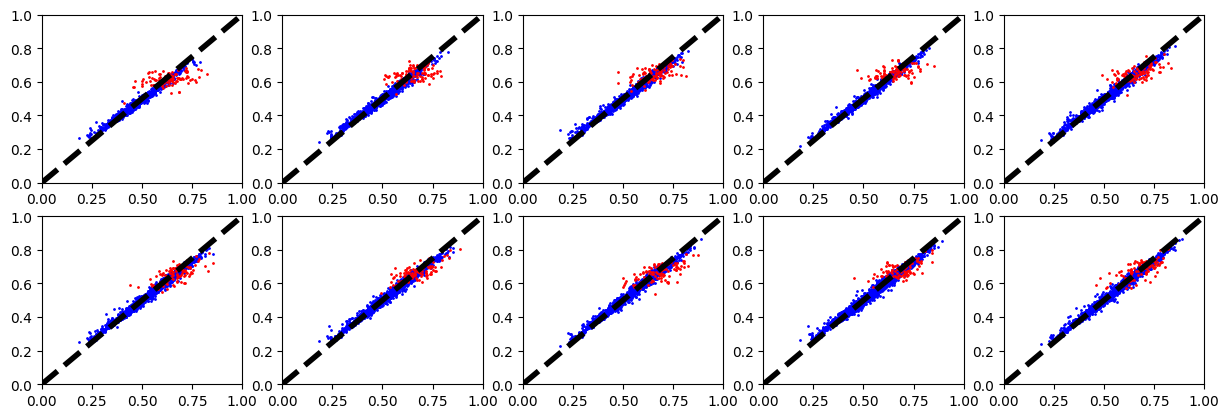

In [35]:
figs, axs = plt.subplots(2,5)
figs.set_figwidth(15)
figs.set_figwidth(15)
for i in range(5):
    axs[0,i].scatter(np.concatenate(data_ym[0:i+1]),data_yp[i][:-100],s=1,c="blue")
    axs[0,i].scatter(data_ym[i+1],data_yp[i][-100:],s=1,c="red")
    axs[0,i].plot([0, 1], [0, 1], 'k--', lw=4)
    axs[0,i].set_xlim(0,1)
    axs[0,i].set_ylim(0,1)
for i in range(5,10):
    axs[1,i-5].scatter(np.concatenate(data_ym[0:i+1]),data_yp[i][:-100],s=1,c="blue")
    axs[1,i-5].scatter(data_ym[i+1],data_yp[i][-100:],s=1,c="red")
    axs[1,i-5].plot([0, 1], [0, 1], 'k--', lw=4)
    axs[1,i-5].set_xlim(0,1)
    axs[1,i-5].set_ylim(0,1)



In [36]:
for i in range(10):
    data_z[i]=np.sort(data_z[i])
    data_z[i]=data_z[i][::-1]

<AxesSubplot:>

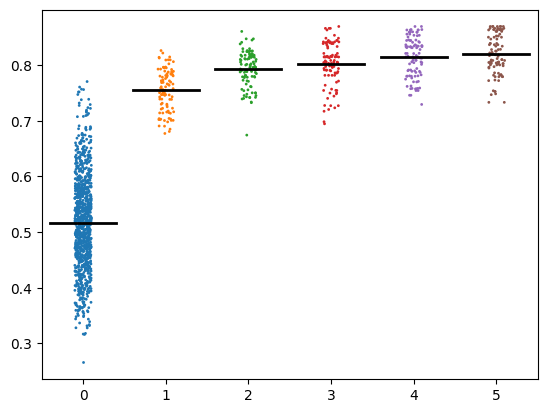

In [45]:
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=20,
            data=data_ym,
            showfliers=False,
            showbox=False,
            showcaps=False)
sns.stripplot(data=data_ym,s=2)

In [39]:
df = pd.DataFrame(np.array([np.mean(data_ym[1:],axis=1), np.std(data_ym[1:],axis=1), np.max(data_ym[1:],axis=1),np.min(data_ym[1:],axis=1)]),
                   columns=['1', '2', '3','4','5','6','7','8','9','10'],index=['mean','std','max','min'])

In [40]:
df

,1,2,3,4,5,6,7,8,9,10
mean,0.631976,0.653433,0.658255,0.661363,0.665049,0.671526,0.669931,0.677139,0.685963,0.676891
std,0.079962,0.068099,0.069580,0.070600,0.071725,0.068949,0.074062,0.081341,0.068852,0.073081
max,0.825179,0.793072,0.813824,0.852494,0.835823,0.852993,0.889258,0.872126,0.842674,0.820276
min,0.411808,0.509235,0.475553,0.466989,0.491980,0.439536,0.493722,0.499118,0.454442,0.461388


In [50]:
def hamming_distance(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def pairwise_hamming_distance(strings):
    distances = []
    for i in range(len(strings)):
        for j in range(i+1, len(strings)):
            distance = hamming_distance(strings[i], strings[j])
            distances.append(distance)
    return distances



In [51]:
pw=[]
for i in range(11):
    pw.append(pairwise_hamming_distance(data_X[i]))

In [52]:
import pandas as pd

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/seaborn/

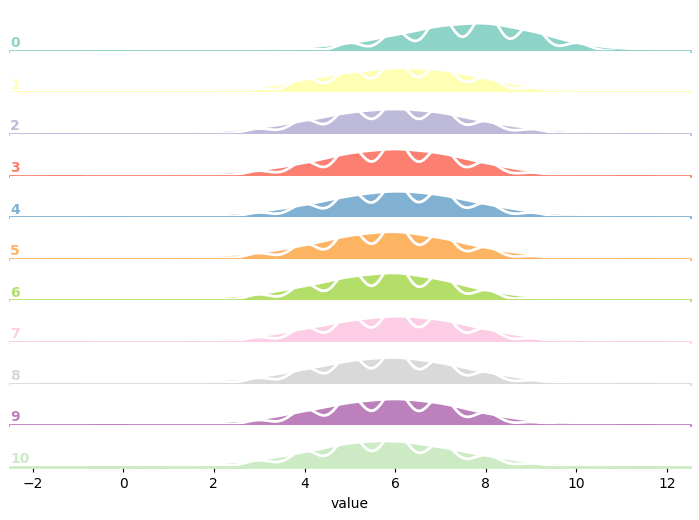

In [53]:
df = pd.DataFrame(pw).transpose()
df = df.melt(var_name='distribution', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(df, row='distribution', hue='distribution', aspect=15, height=0.5, palette='Set3')

# Map a kdeplot onto each facet
g.map(sns.kdeplot, 'value', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.4)
g.map(sns.kdeplot, 'value', clip_on=False, color='w', lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'value')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

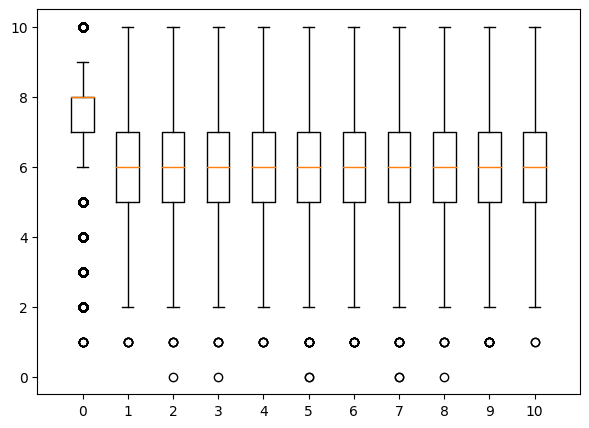

In [54]:
plt.figure(figsize=(7,5))
plt.boxplot(pw)

plt.xlim(0, 12)
plt.xticks(np.arange(1, 12), np.arange(11))

# Show the plot
plt.show()